# Test of Doppler lags for the observed oscillations
    
Following tests are scripted for comprehensive characterization
- convergence to reference orbit with zero lags
- impact of a uniform lag in the Doppler (range rate) data
- impact of light-time lags, i.e., radial acceleration and light time
- impact of light-time lags times a scale factor


In [1]:
from astropy import units as u
sampling_interval = 1*u.hour
tracking_period = 5*u.day

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris
    
from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray
    
import numpy as np
import sys
sys.path.append('../')
    
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
    
from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs, find_rates
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter
    
def plots(epochs, residual, title, ylab):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)
    try:
        plot_swings(epochs, residual, None, 'Residual swings ' + ylab)
    except ValueError:
        # no swings identified
        pass
    
def fitv(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_doppler_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'doppler (m/s)')
    return fitter
    
def reusefitv(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.doppler_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'doppler (m/s)')
    return residual
    
def fitr(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_range_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'range (m)')
    rates = find_rates(epochs, fitter.result.residual)
    plots(epochs[1:], rates, None, 'range rate (m/s)')
    return fitter, rates
    
def reusefitr(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.range_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'range (m)')
    rates = find_rates(epochs, residual)
    plots(epochs[11:], rates[10:], None, 'range rate (m/s)')
    return rates

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
    
near_goldstone_orbit = orbit_from_horizons("NEAR", goldstone_end)
describe_orbit(near_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + tracking_period
epochs = make_epochs(canberra_start, canberra_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")
    
near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(epochs))
describe_trajectory(near_extended_ephem, dss34)

Start and end: 1998-01-23 09:53:55.600 1998-01-28 08:53:55.600 [ 120 ]

::TRAJECTORY::
Start and end ranges: 99245.7532096098 km 3036239.0077683222 km
Start and end radial speeds: 7.3216176182785535 km / s 6.784349119880077 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.4576006592003391 deg


In [5]:
vdata_ref = []
vlags = []
vlags_full = []
vdata_constvlags = []
vdata_ltlags_full = []
vdata_ltlags = []
vdata_scaledlags = []
    
rdata_ref = []
rlags = []
rlags_full = []
rdata_constrlags = []
rdata_ltlags_full = []
rdata_ltlags = []
rdata_scaledlags = []
    
scalefactor = 0.1
first_vlag = None
first_rlag = None
    
for e in epochs[:-1]:
    ref_r, ref_rr, ref_ra, ref_rs = dss34.range_rate_accel(near_extended_ephem, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_ra.to_value(u.m/(u.s*u.s)),
         ref_rs.to_value(u.m/(u.s*u.s)),
         (ref_ra+ref_rs).to_value(u.m/(u.s*u.s)),
         )
    
    vlag_full = ref_ra*ref_r/const.c
    vlag = (ref_ra+ref_rs)*ref_r/const.c
    
    if first_vlag is None:
        first_vlag = vlag
    
    vlags.append(vlag)
    vlags_full.append(vlag_full)
    
    vdata_ref.append([ref_rr])
    vdata_constvlags.append([ref_rr - first_vlag])
    vdata_ltlags_full.append([ref_rr - vlag_full])
    vdata_ltlags.append([ref_rr - vlag])
    vdata_scaledlags.append([ref_rr - scalefactor*vlag])
    
for e in epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_rs = dss34.range_and_rates(rv, e)
    print(e.strftime("%H:%M:%S"),
         ref_r.to_value(u.km),
         ref_rr.to_value(u.m/u.s),
         ref_rs.to_value(u.m/u.s),
         (ref_rr+ref_rs).to_value(u.m/u.s),
         )
    
    rlag_full = ref_rr*ref_r/const.c
    rlag = (ref_rr+ref_rs)*ref_r/const.c
    
    if first_rlag is None:
        first_rlag = rlag
    
    rlags.append(rlag)
    rlags_full.append(rlag_full)
    
    rdata_ref.append([ref_r])
    rdata_constrlags.append([ref_r - first_rlag])
    rdata_ltlags_full.append([ref_r - rlag_full])
    rdata_ltlags.append([ref_r - rlag])
    rdata_scaledlags.append([ref_r - scalefactor*rlag])

09:53:55 73145.82143191747 -0.04185589375538257 0.01192843359500273 -0.029927460160379837
10:53:55 99245.7532096098 -0.03059583885089978 0.00693192085350347 -0.02366391799739631
11:53:55 124953.15770282669 -0.019042220756659844 0.003217205848670801 -0.015825014907989043
12:53:55 150407.26865298714 -0.011860758101001068 2.649666981824339e-06 -0.011858108434019243
13:53:55 175706.3273609694 -0.0061811455198679255 -0.002839522583883536 -0.009020668103751461
14:53:55 200923.61747138412 -0.0019067205281331212 -0.0052638765777146546 -0.007170597105847777
15:53:55 226115.081514972 0.0013292310754309256 -0.00718074742607655 -0.005851516350645625
16:53:55 251322.7147374973 0.0036045875928536475 -0.008504513680904324 -0.004899926088050678
17:53:55 276576.09410904173 0.004988653794057996 -0.00917620543836506 -0.004187551644307065
18:53:55 301893.2139723953 0.005533782702293877 -0.009174524770680037 -0.003640742068386161
19:53:55 327281.2187505763 0.005310967222449392 -0.008520129656403697 -0.0032

17:53:55 2662495.4370598304 0.008549464323159839 -0.008600378944833231 -5.0914621673392256e-05
18:53:55 2687292.436792106 0.008237652638243276 -0.008288135473264902 -5.0482835021626736e-05
19:53:55 2712195.580307736 0.007356269764002832 -0.007406588795667801 -5.031903166496943e-05
20:53:55 2737193.511970566 0.00596631707683315 -0.006016669686204068 -5.0352609370918175e-05
21:53:55 2762268.322841211 0.004163768865694806 -0.004214277337197814 -5.050847150300766e-05
22:53:55 2787396.7871512296 0.002072843533262869 -0.002123555973369662 -5.071244010679266e-05
23:53:55 2812551.9627528093 -0.00016264813762489894 0.00011175300411991884 -5.0895133504980095e-05
00:53:55 2837705.044099516 -0.002389249807777105 0.0023382553756050584 -5.099443217204694e-05
01:53:55 2862827.339612924 -0.004454398369269086 0.004403441363066918 -5.0957006202168255e-05
02:53:55 2887892.2376337643 -0.006216829331329166 0.006166089958739462 -5.073937258970295e-05
03:53:55 2912877.026864835 -0.007556151906840114 0.007505

21:53:55 2168346.52378132 6978.391728571892 -101.49148849919577 6876.900240072696
22:53:55 2193492.206695077 6990.185190594644 -113.57899528494923 6876.606195309695
23:53:55 2218666.4763589315 6994.179303992086 -117.86692818269731 6876.312375809389
00:53:55 2243840.5698279594 6990.085507398562 -114.06643611450704 6876.019071284055
01:53:55 2268985.684824513 6978.170407387048 -102.44350913087689 6875.726898256171
02:53:55 2294074.954473082 6959.236248363592 -83.79950834905387 6875.436740014538
03:53:55 2319085.285435454 6934.565029526202 -59.41534697465455 6875.149682551547
04:53:55 2343998.9351332914 6905.8302927473305 -30.963347360819057 6874.866945386511
05:53:55 2368804.7220748416 6874.982667730647 -0.39286218358390856 6874.589805547063
06:53:55 2393498.7882963875 6844.116901764919 30.202612429556922 6874.319514194476
07:53:55 2418084.8629738037 6815.329249670275 58.72795835064882 6874.057208020924
08:53:55 2442574.0094743236 6790.574706686827 83.22911408674885 6873.803820773576
09:

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 119
    # variables        = 6
    chi-square         = 1.4756e-04
    reduced chi-square = 1.3058e-06
    Akaike info crit   = -1606.44799
    Bayesian info crit = -1589.77325
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83945736 (init = -1.839425)
    raan:  1.54000415 (init = 1.540059)
    argp:  2.53324142 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:00:07.370973

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.001

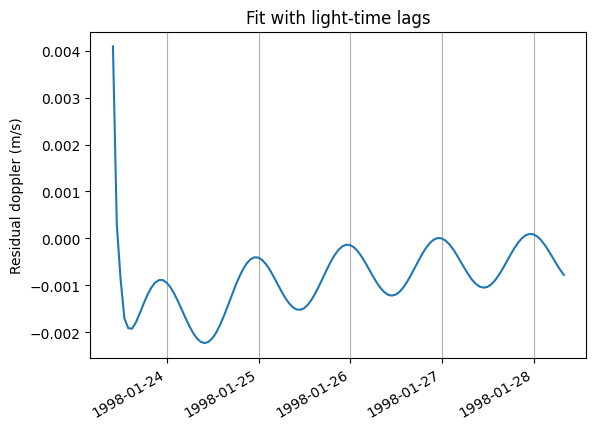

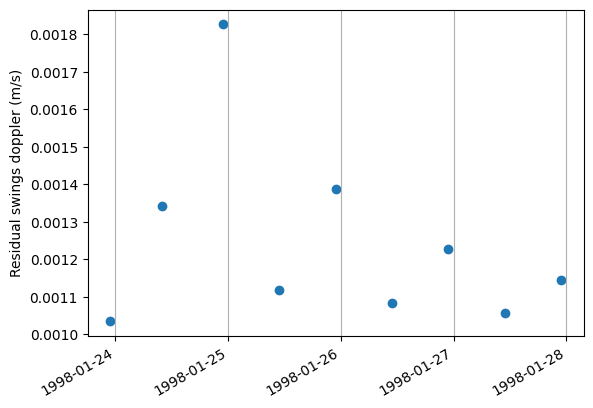

In [6]:
ltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags, "Fit with light-time lags")

[0.0033387726741947177, 0.0031904672505334714, 0.003270653348105723, 0.0031887229609614404]


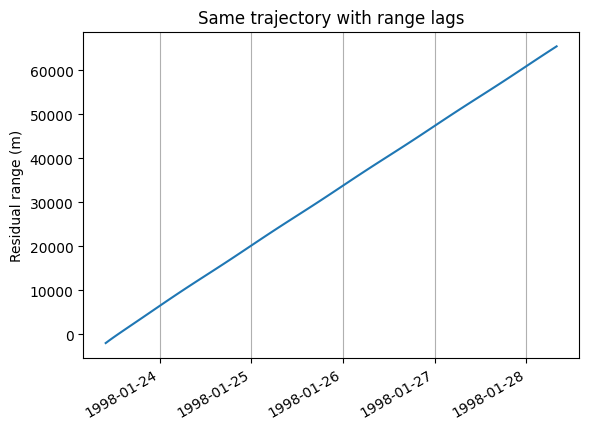

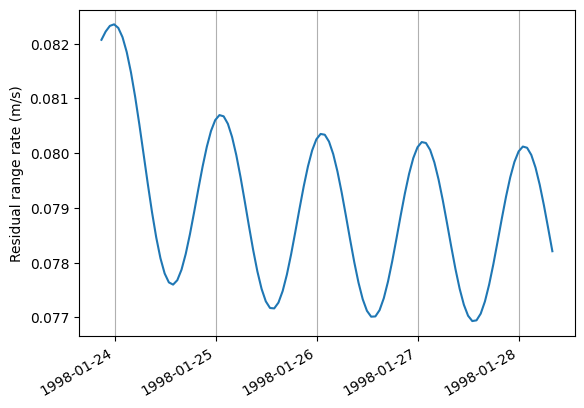

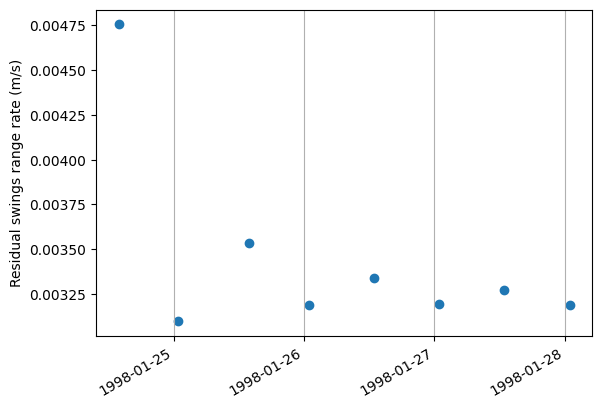

In [7]:
_ = ltresr_rates = reusefitr(ltfitv, epochs[:-1], rdata_ltlags, "Same trajectory with range lags")

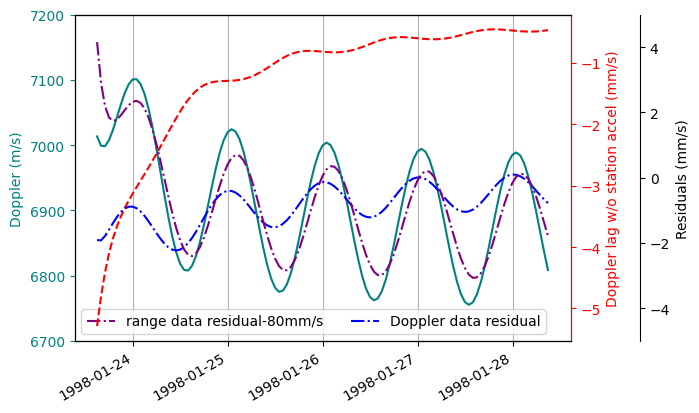

In [13]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('')
    plt.grid(axis='x')

    if tracking_period > 5*u.day:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    ax.set_ylabel('Doppler (m/s)', color = "teal")
    ax.spines['left'].set(color="teal")
    ax.tick_params(axis="y", colors="teal")
    ax.set_ylim([6700, 7200])
            
    ax2 = ax.twinx()
    ax2.set_ylabel('Doppler lag w/o station accel (mm/s)', color = "red")
    ax2.spines['right'].set(color="red")
    ax2.tick_params(axis="y", colors="red")

    ax3 = ax.twinx()
    ax3.set_ylabel('Residuals (mm/s)', color = "black")
    ax3.spines['right'].set_position(('outward', 50))
    ax3.set_ylim([-5, 5])

    p1, = ax.plot(epochs[5:], [v[0].to_value(u.m/u.s) for v in vdata_ref[4:]], 
                  color="teal", label="Doppler")
    p2, = ax2.plot(epochs[5:], [v.to_value(u.mm/u.s) for v in vlags[4:]],
                   linestyle = "dashed", color="red", label="lag w/o station accel")
    
    p3, = ax3.plot(epochs[5:], [1e3*v for v in ltfitv.result.residual[4:]],
                   linestyle='-.', color="blue", label="Doppler data residual")
    p4, = ax3.plot(epochs[5:], [1e3*v-80 for v in ltresr_rates[3:]],
                   linestyle='-.', color="purple", label="range data residual-80mm/s")

    ax.legend(handles=[p4, p3], loc="lower left", ncol=2)
    plt.gcf().autofmt_xdate()

    plt.savefig(f'near_sim_postencounter-{int(tracking_period.to_value(u.day))}d.pdf', bbox_inches='tight')